# Ford GoBike System Data Exploration

## Investigation Overview

In this project, we will be finding out what features contribute to higher usage rate and longer duration time. The main focus includes day of the week, hour of the day, and user types. 

## Dataset Overview

The dataset we use in this project consists of the information about 258,000 trips of Bay Wheels bike system in July, 2019. The data includes duration time, start/end time, start/end station location and ID, bike's ID, and some subscription's information. To help investigate the features of the dataset, three variables are added, starting hour of the day, day of the week, and duration time in minutes.

In [1]:
# import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# load the dataset - baywheels trip data in July 2019
bike = pd.read_csv('201907-baywheels-tripdata.csv')

/Users/lawrencetseng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# convert columns start_time and end_time to timestamp datatype
bike['start_time'] = pd.to_datetime(bike['start_time'])
bike['end_time'] = pd.to_datetime(bike['end_time'])
bike['start_time'] = bike['start_time'].astype('datetime64[s]')
bike['end_time'] = bike['end_time'].astype('datetime64[s]')

In [4]:
# add "day of week" column
day_list = []

for d in range(len(bike)):
    day = bike['start_time'][d].day_name()
    day_list.append(day)
    
bike['start_day'] = day_list

In [5]:
# add "hour" column
hour_list = []

for h in range(len(bike)):
    hour = bike['start_time'][h].hour
    hour_list.append(hour)
    
bike['hour'] = hour_list

In [6]:
# convert seconds to minutes
bike['duration_min'] = (bike['duration_sec']/60).round(2)

In [7]:
# convert start day into ordered categorical types
ordinal_var_dict = {'start_day': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, 
                                                categories = ordinal_var_dict[var])
    bike[var] = bike[var].astype(ordered_var)

## Distribution of Duration

Duration time (min) have a very large range of value, ranging from 1 minute to 1436 minutes. In a log-scale plot, the duration time looks like a unimodal distribution, with the peak between 8 and 10 minutes.

In [8]:
np.log10(bike['duration_min'].describe())

count    5.411791
mean     1.147014
std      1.464390
min      0.000000
25%      0.794488
50%      0.996512
75%      1.191171
max      3.157442
Name: duration_min, dtype: float64

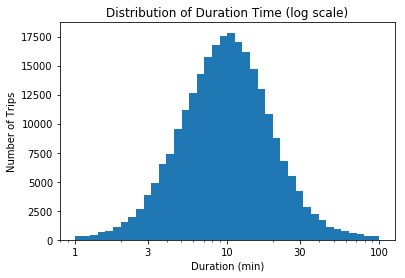

In [9]:
# try a log scaled plot
base_color = sb.color_palette()[0]
bins = 10 ** np.arange(0, 2 + 0.05, 0.05)
ticks = [1, 3, 10, 30, 100]
labels = ['{}'.format(v) for v in ticks]
plt.hist(data = bike, x = 'duration_min', bins = bins);
plt.xscale('log');
plt.xlabel('Duration (min)');
plt.xticks(ticks, labels);
plt.ylabel('Number of Trips');
plt.title('Distribution of Duration Time (log scale)');

## Different Days of the Week

The amount of trips on weekdays are generally more than those on weekends, and the numbers from Mondays to Wednesdays are higher than Thursdays and Fridays. The amount of bike trips used by *Subscribers* takes a larger proportion of total trips, which will have greater impact on the overall usage pattern.

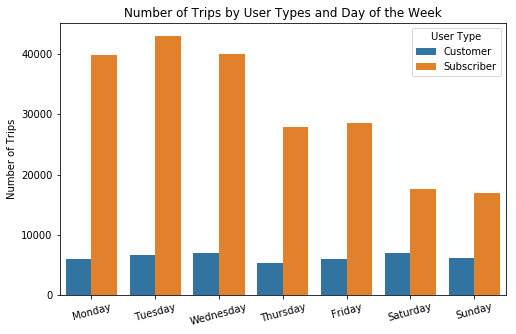

In [10]:
plt.figure(figsize = [8,5])
sb.countplot(data = bike, x = 'start_day', hue = 'user_type');

plt.xlabel('');
plt.ylabel('Number of Trips');
plt.xticks(rotation = 15);
plt.legend(title = 'User Type');
plt.title('Number of Trips by User Types and Day of the Week');

## Different Hours of the Day

The duration time shows a totally different pattern as the number of trips by hours of the day. The mean duration times (min) are relatively shorter during morning and afternoon peak hours. This can explain why the number of trips is higher on weekdays and why most users have their membership. Most of the users are commuters who use Bay Wheels as their transportation mode to travel between train/bus stations and offices. This section of the daily commuting is usually short, and the users are familiar with their routes.

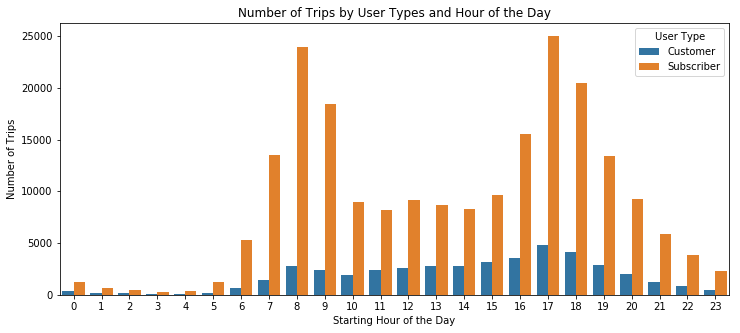

In [11]:
plt.figure(figsize = [12,5])
sb.countplot(data = bike, x = 'hour', hue = 'user_type');

plt.xlabel('Starting Hour of the Day');
plt.ylabel('Number of Trips');
plt.legend(title = 'User Type');
plt.title('Number of Trips by User Types and Hour of the Day');

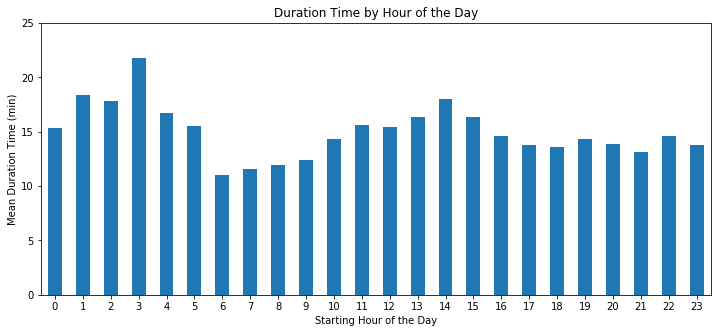

In [12]:
plt.figure(figsize = [12,5])
bike.groupby('hour')['duration_min'].mean().plot(kind = 'bar', color = base_color);

plt.ylim(0, 25);
plt.xlabel('Starting Hour of the Day');
plt.ylabel('Mean Duration Time (min)');
plt.xticks(rotation = 0);
plt.title('Duration Time by Hour of the Day');

## Duration Time by Days of the Week and User Types

*Subscribers* generally spend less time using GoBike than *Customers*. The average duration time of *Subscribers* on weekdays and weekends are almost the same, between 11 and 14 minutes. The mean duration times are relatively shorter during morning and afternoon peak hours.On the other hand, the average duration time of *Customers* increases nearly 30% on weekends. It is reasonable that most *Customers* might consist of tourists who use the system once in a while and tend to ride GoBike longer than normal commuters.

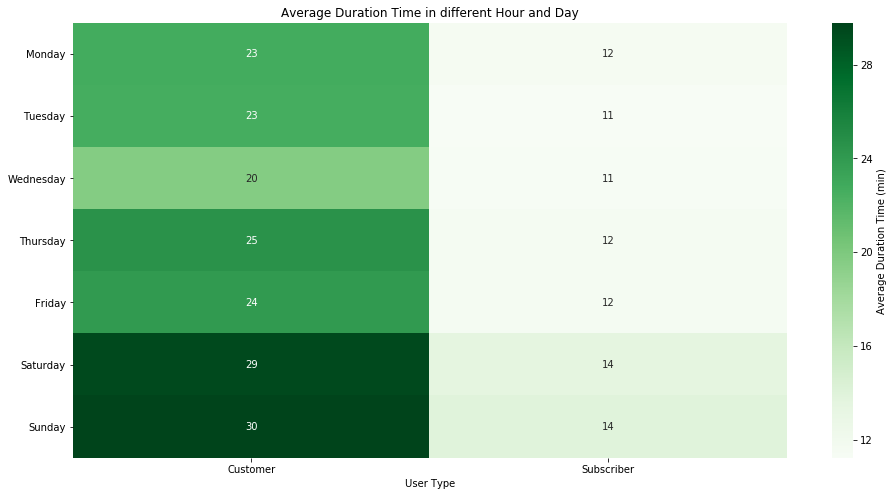

In [13]:
plt.figure(figsize = [16, 8]);
cat_means = bike.groupby(['user_type', 'start_day']).mean()['duration_min']
cat_means = cat_means.reset_index(name = 'duration_min_avg')
cat_means = cat_means.pivot(index = 'start_day', columns = 'user_type', values = 'duration_min_avg')
sb.heatmap(cat_means, annot = True, cbar_kws = {'label': 'Average Duration Time (min)'}, cmap = 'Greens');
plt.xlabel('User Type');
plt.ylabel('');
plt.yticks(rotation = 0);
plt.title('Average Duration Time in different Hour and Day');

## Number of Trips by Different Hours and Days

We can see that the number of trips by different hour and day appears like a bimodal graph on weekdays, which peaks during morning and afternoon peak hours. On weekends, it gradually increases in the morning, peaks at noon, and then slowly decreases in the evening.  The number of trips of *Customers* does not change as significantly as those of *Subscribers* does on weekdays while the patterns are similar on weekends.

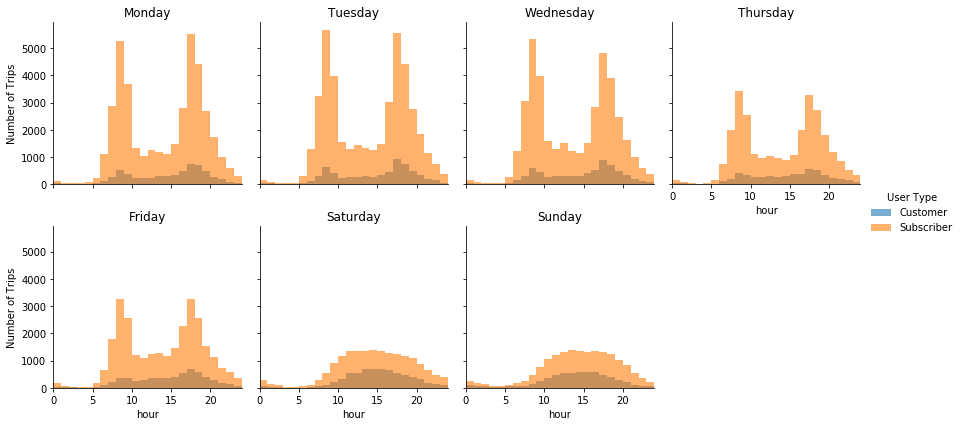

In [14]:
bins = np.arange(0, 23+2, 1);
g = sb.FacetGrid(data = bike, col = 'start_day', hue = 'user_type', col_wrap = 4);
g.map(plt.hist, 'hour', bins = bins, alpha = 0.6).add_legend(title = 'User Type');
plt.xlim(0, 24);
axes = g.axes.flatten()
axes[0].set_title('Monday')
axes[1].set_title('Tuesday')
axes[2].set_title('Wednesday')
axes[3].set_title('Thursday')
axes[4].set_title('Friday')
axes[5].set_title('Saturday')
axes[6].set_title('Sunday');
axes[0].set_ylabel('Number of Trips')
axes[4].set_ylabel('Number of Trips');